## Initial imports and constants used in all cells

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import networkx as nx
import os, ntpath, json
import ringo

FINAL_DF_NAME = 'benchmark_stats.csv'

SI_DATA_DIR = './si_data'
TESTSET_OVERVIEW_CSV = os.path.join(SI_DATA_DIR, 'testset_overview.csv')

METHOD_NAMES = {
    'ringointel': 'Ringo',
    'rdkit': 'RDKit',
    'mtd': 'XTB metadynamics',
    'mmbasic': 'MacroModel LowMode+torsional sampling',
    'mmring': 'Macrocycle sampling in MacroModel',
    'crest': 'CREST',
}
ALL_METHODS = ['ringointel', 'rdkit', 'mtd']
FULL_CASES_ORDER = ['pdb_3M6G', 'csd_FINWEE10', 'pdb_2IYA', 'csd_YIVNOG', 'pdb_1NWX', 'csd_RULSUN', 'csd_MIWTER', 'pdb_2C6H', 'csd_RECRAT', 'pdb_2QZK']

PLOT_MODES = {
    'low_energy': {
        'timing_compute': lambda df: df['time'] / df['n_lower_unique'] * df['thread_avg'],
        'time_cutoff': 100.0, # seconds per conformer
        'y_caption': 'Time per unique\nlow-energy conformer, s',
    },
    'any_energy': {
        'timing_compute': lambda df: df['time'] / (df['n_lower_unique'] + df['n_higher_unique']) * df['thread_avg'],
        'time_cutoff': 10.0, # seconds per conformer
        'y_caption': 'Time per unique\nconformer, s',
    },
}


## Generate plots

In [ ]:
def plot_df(df, y_caption, result_file, show_legend, time_cutoff=None):
    from plotnine import ggplot, aes, labs, scale_fill_manual, theme_bw, element_text, theme, element_blank, element_rect, element_line, geom_bar, position_dodge, ylim
    normal_theme = (theme_bw() +
                    theme(panel_grid_major = element_blank(),
                        panel_grid_minor = element_blank(),
                        panel_border = element_rect(colour='black', fill=None, size=1),
                        axis_line = element_line(colour='black'),
                        axis_title = element_text(size=16, face='bold', ma='center'),
                        axis_text = element_text(size=14),
                        legend_title = element_text(size=14, face='bold'),
                        legend_text = element_text(size=14),
                        figure_size=(10, 4)))

    # Colors from Set2
    colorscheme = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#a65628", "#f781bf"]

    plot = ggplot(df, aes(y='time_per_conf', x='testcase', fill='Sampling method')) + \
        geom_bar(stat='identity', position=position_dodge(width=0.9)) + \
        labs(y=y_caption, x='') + normal_theme + \
        theme(axis_text_x = element_text(angle = 60)) + scale_fill_manual(values=colorscheme)
    if time_cutoff is not None:
        plot += ylim(0, time_cutoff)
    if not show_legend:
        plot += theme(legend_position="none")
    
    print(plot)
    plot.save(result_file, verbose=False)

def plot_ten_molecules(timing_compute, **kwargs):
    df = pd.read_csv(FINAL_DF_NAME)
    df['time_per_conf'] = timing_compute(df)
    df['method'] = df['method'].replace(METHOD_NAMES)
    method_type = CategoricalDtype(categories=[method_name for method_name in METHOD_NAMES.values()], ordered=True)
    df['method'] = df['method'].astype(method_type)    
    
    # Use predefined ordering of testcases on the plot
    testcase_type = CategoricalDtype(categories=FULL_CASES_ORDER, ordered=True)
    df['testcase'] = df['testcase'].astype(testcase_type)
    df = df[df['testcase'].isin(FULL_CASES_ORDER)]

    df = df.rename(columns={'method': 'Sampling method'})

    df['testcase'] = df['testcase'].str.replace('csd_', '')
    df['testcase'] = df['testcase'].str.replace('pdb_', '')
    testcase_type = CategoricalDtype(categories=[x.replace('csd_', '').replace('pdb_', '') for x in FULL_CASES_ORDER], ordered=True)
    df['testcase'] = df['testcase'].astype(testcase_type)

    # Cut bar heights
    if 'time_cutoff' in kwargs:
        df['time_per_conf'] = df['time_per_conf'].apply(lambda x: kwargs['time_cutoff'] if x > kwargs['time_cutoff'] else x)

    plot_df(df, **kwargs)

def plot_all_molecules(timing_compute, **kwargs):
    df = pd.read_csv(FINAL_DF_NAME)
    df['time_per_conf'] = timing_compute(df)
    # Cut the bar heights if required
    if 'time_cutoff' in kwargs:
        df['time_per_conf'] = df['time_per_conf'].apply(lambda x: kwargs['time_cutoff'] if x > kwargs['time_cutoff'] else x)
    
    df = df[df['method'].isin(ALL_METHODS)]
    df['method'] = df['method'].replace(METHOD_NAMES)
    method_type = CategoricalDtype(categories=[method_name for method_name in METHOD_NAMES.values()], ordered=True)
    df['method'] = df['method'].astype(method_type)    
    
    df = df[~df['testcase'].isin(FULL_CASES_ORDER)]
    df['testcase'] = df['testcase'].str.replace('csd_', '')
    df['testcase'] = df['testcase'].str.replace('pdb_', '')
    order_df = df.loc[df['method'] == METHOD_NAMES['ringointel']].sort_values(by=['time_per_conf'], ascending=False)
    order_df = order_df.reset_index()
    cat_type = CategoricalDtype(categories=order_df['testcase'], ordered=True)

    df = df.rename(columns={'method': 'Sampling method'})
    df = df.reset_index()

    step_size = 20
    for i in range(0, len(order_df['testcase']), step_size):
        current_testcases = order_df['testcase'][i : i + step_size]
        cur_df = df[df['testcase'].isin(current_testcases)].copy()
        cur_df['testcase'] = cur_df['testcase'].astype(cat_type)
        cur_kwargs = {
            **kwargs,
            'result_file': kwargs['result_file'].format(plot_type=i)
        }
        plot_df(cur_df, **cur_kwargs)

    # # Initial ideas of choosing ordering of testcases on the plot
    # # sort the dataframe by time in descending order for 'noref' and 'succ'
    # order_df = df.loc[df['method'] == METHOD_NAMES['crest']].sort_values(by=['time_per_conf'], ascending=False)
    # order_df = df.loc[df['method'] == METHOD_NAMES['rdkit']].sort_values(by=['time_per_conf'], ascending=False)
    # hardest_cases = order_df['testcase'] # .tail(30).head(40)
    # df = df[df['testcase'].isin(hardest_cases)]
    # # convert 'testcase' column to categorical datatype with sorted order
    # cat_type = CategoricalDtype(categories=order_df['testcase'], ordered=True)
    # df['testcase'] = df['testcase'].astype(cat_type)

    # Some selections for in-depths analysis
    # df = df[(df['method'] == METHOD_NAMES['ringointel']) | (df['method'] == METHOD_NAMES['rdkit'])]
    # df = df[df['method'] != METHOD_NAMES['mmbasic']]

In [ ]:
# Plots of figures for main text
# Hatches were added by hand in Adobe Illustrator
for plotting_mode, basic_kwargs in PLOT_MODES.items():
    print(f'============\n{plotting_mode}\n============')
    plotting_kwargs = {
        **basic_kwargs,
        'show_legend': True,
        'result_file': os.path.join(SI_DATA_DIR, f'{plotting_mode}_timings.svg'),
    }
    plot_ten_molecules(**plotting_kwargs)

In [ ]:
# Plots of figures for SI
# Hatches were added by hand in Adobe Illustrator
for plotting_mode, basic_kwargs in PLOT_MODES.items():
    print(f'============\n{plotting_mode}\n============')
    plotting_kwargs = {
        **basic_kwargs,
        'show_legend': False,
        'result_file': os.path.join(SI_DATA_DIR, f'{plotting_mode}_si.svg'),
    }
    del plotting_kwargs['time_cutoff']
    plot_ten_molecules(**plotting_kwargs)

    plotting_kwargs['result_file'] = os.path.join(SI_DATA_DIR, '%s_{plot_type}.png' % plotting_mode)
    plot_all_molecules(**plotting_kwargs)

## Generate CSVs for SI with testset overview and benchmark data

In [2]:
from charges import CHARGES
    
TESTSET_JSON = 'testcases.json'
with open(TESTSET_JSON, 'r') as f:
    sdf_mapping = json.load(f)

df = pd.read_csv(FINAL_DF_NAME)
# Load testset overview
testcases = df['testcase'].unique()

# Print the structure of testset
testcases_list = list(testcases)
testset_parts = set(name.split('_')[0] for name in testcases_list)
for part_idx, testset_part in enumerate(testset_parts):
    molecule_ids = [name.split('_')[1] for name in testcases_list if name.startswith(testset_part)]
    print(f'{part_idx+1}) {testset_part.upper()}: {", ".join(sorted(molecule_ids))}')

# Generate overview
overview_df = pd.DataFrame()
overview_df['testcase'] = testcases
def get_overview(row):
    molname = row['testcase']

    m = ringo.Molecule(sdf_mapping[molname])
    result = ringo.get_molecule_statistics(m)
    result['composition'] = ''.join([f'{element}{count}' for element, count in result['composition'].items()])
    
    if molname in CHARGES:
        charge = CHARGES[molname]
    else:
        charge = 0
    result['charge'] = charge

    return pd.Series(result)
new_columns = overview_df.apply(get_overview, axis=1)
overview_df = pd.concat([overview_df, new_columns], axis=1)
overview_df = overview_df.rename(columns={
    'method': 'Sampling method',
    'composition': 'Composition',
    'charge': 'Total charge',
    'num_atoms': 'Number of atoms',
    'num_heavy_atoms': 'Number of heavy atoms',
    'num_bonds': 'Number of bonds',
    'num_rotatable_bonds': 'Number of rotatable bonds',
    'num_cyclic_rotatable_bonds': 'Number of cyclic rotatable bonds',
    'n_flexible_rings': 'Number of flexible cycles',
    'n_rigid_rings': 'Number of rigid cycles',
    'largest_macrocycle_size': 'Largest macrocycle size',
    'num_dofs': 'Number of kinematic DOFs',
    'cyclomatic_number': 'Cyclomatic number (n_edges-n_atoms+1)',
})
overview_df.to_csv(TESTSET_OVERVIEW_CSV, index=False)

# Load benchmark data
for item in PLOT_MODES.values():
    df[item['y_caption']] = item['timing_compute'](df)
df['method'] = df['method'].replace(METHOD_NAMES)
df = df.drop(columns=[
    'n_failed_opts',
])
df = df.rename(columns={
    'method': 'Sampling method',
    'n_total_generated': 'Conformations generated',
    'n_unique_generated': 'Unique conformers generated',
    'n_duplicates': 'Duplicates after optimization',
    'n_failed_topo': 'Incorrect topology after optimization',
    'n_higher_unique': 'High-energy conformations (>15 kcal/mol)',
    'n_lower_unique': 'Low-energy conformations (<15 kcal/mol)',
})
df.to_csv(os.path.join(SI_DATA_DIR, 'timings_results.csv'), index=False)

1) PDB: 1A7X, 1BXO, 1BZL, 1E9W, 1EHL, 1ESV, 1FKD, 1FKI, 1FKJ, 1FKL, 1GHG, 1JFF, 1KEG, 1KHR, 1MRL, 1NMK, 1NSG, 1NT1, 1NTK, 1NWX, 1OSF, 1PFE, 1PKF, 1PPJ, 1QPF, 1QPL, 1QZ5, 1QZ6, 1S22, 1SKX, 1TPS, 1WUA, 1XBP, 1XS7, 1YET, 1YND, 1YXQ, 2ASM, 2ASO, 2ASP, 2C6H, 2C7X, 2DG4, 2F3E, 2F3F, 2GPL, 2IYA, 2IYF, 2OTJ, 2PH8, 2Q0R, 2QZK, 2VYP, 2VZM, 2WEA, 2WHW, 2XBK, 3ABA, 3BXR, 3DV1, 3DV5, 3EKS, 3I6O, 3K5C, 3KEE, 3M6G, 7UPJ
2) CSD: AAGGAG10, ABOJOR, ABOMOT, ACICOE, BIDPIN10, BIHYAS10, CAHWEN, CALSAR, CAMVES01, CAZVEF, CGPGAP10, CHPSAR, CIYKUR, CIYLAY, CLPGDH, COHVAW, CTILIH10, CTVHVH01, CUQRUB, CYVIHV10, DACMAW, DAFGIA, DALPUC, DEKSAN, DIGTOC, FAGFEZ, FEGJAD, FINWEE10, FIVSAE, FIXYEQ, GAFSEL, GEZBUI, GIHKOX10, HAXMOI10, HEBLIJ, HIKPAS01, ICYSPA, IDIMAJ, JINWUZ, JOKSAD, KAQJAN, KAQJER, KIVDIC, LALWIF, MALVAL10, MECBOL, MIWTER, MUCYIT, NITFEB, NUCZUH, OHIDUE, OHIFAM, OHUXEU, PAPGAP, POXTRD10, QEKNID, QOSNAN, QUDRIQ, QUDROW, RASTIO, RECRAT, REMCOC, RULSUN, RUQVAB, TERDAW, VAKPIH, VALINM30, VOKBIG, VOLHOU, V

### Compare MC against MCR

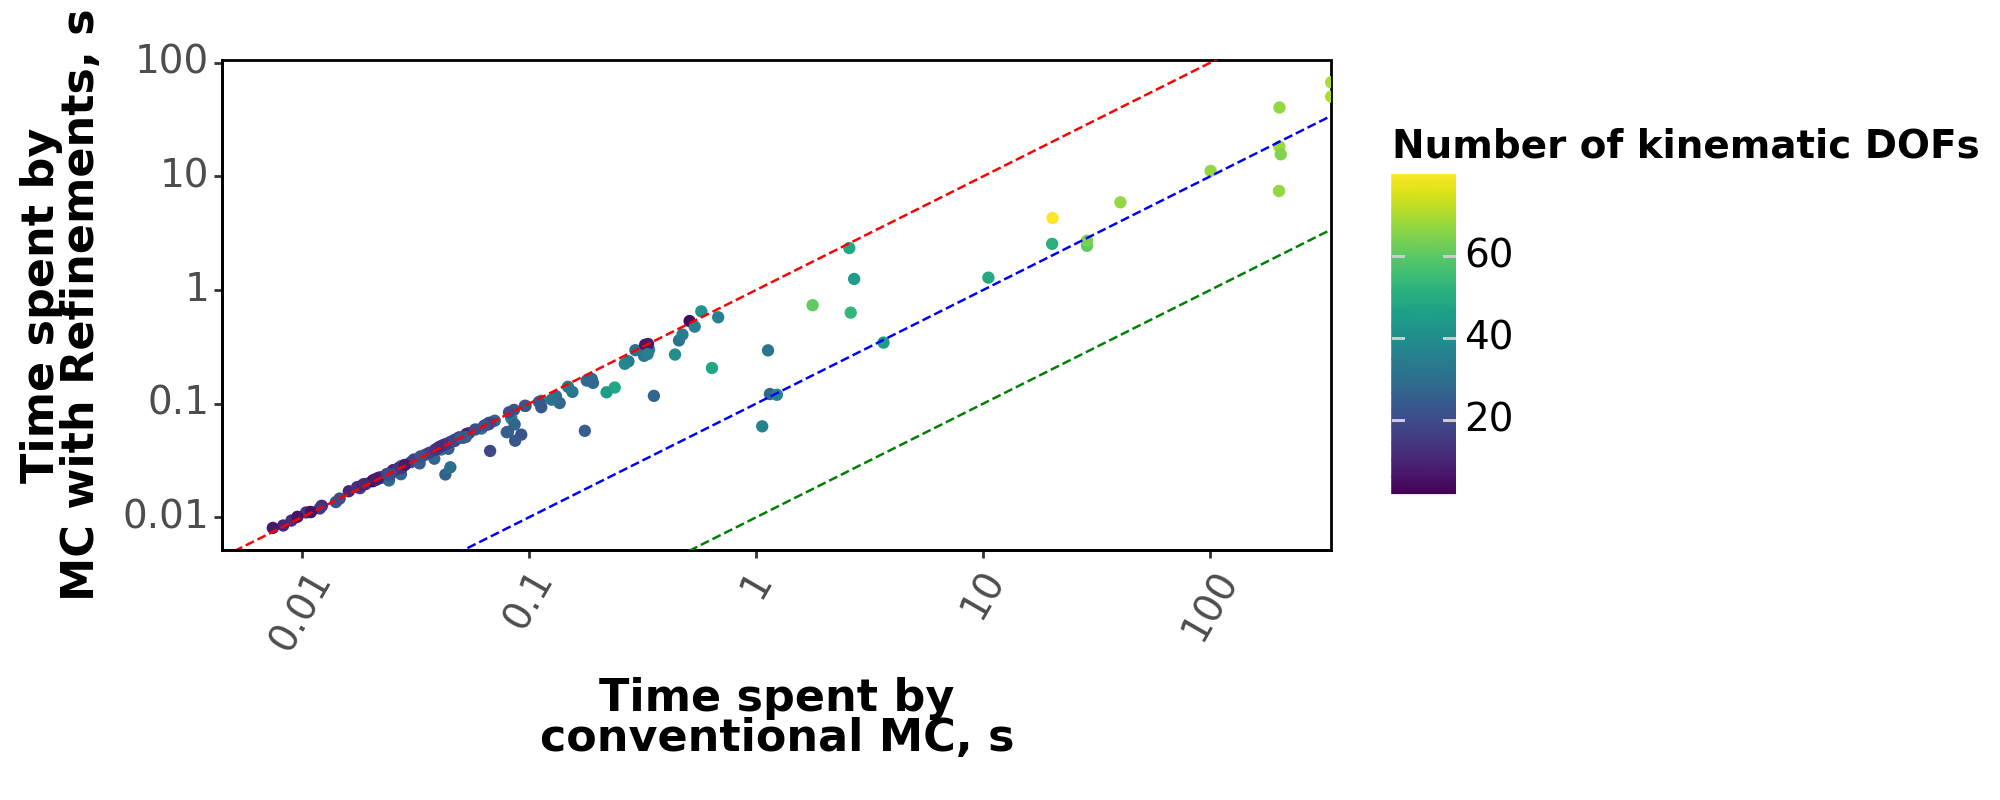

In [8]:
df = pd.concat([
    pd.read_csv(csvfile)
    for csvfile in ('ringoMC_mcmode.csv', 'ringoMCR_mcmode.csv')
], ignore_index=True)
df['time_per_conf'] = df['time'] / df['nunique']

# # Cut the bar heights if required
# if 'time_cutoff' in kwargs:
# df['time_per_conf'] = df['time_per_conf'].apply(lambda x: 10.0 if x > 10.0 else x)

METHOD_NAMES = {
    'ringoMC': 'conventional MC',
    'ringoMCR': 'MC with Refinements',
}

AXIS_NAMES = {
    key: f'Time spent by\n{value}, s'
    for key, value in METHOD_NAMES.items()
}

df['testcase'] = df['testcase'].str.replace('csd_', '')
df['testcase'] = df['testcase'].str.replace('pdb_', '')

df = df.pivot(index='testcase', columns='method', values='time_per_conf').reset_index()
df.columns.name = None  # Remove the columns' name
# df = df.rename(columns={'ringoMC': 'time_MC', 'ringoMCR': 'time_MCR'})
df = df.rename(columns=AXIS_NAMES)

overview_df = pd.read_csv(TESTSET_OVERVIEW_CSV)
overview_df['testcase'] = overview_df['testcase'].str.replace('csd_', '')
overview_df['testcase'] = overview_df['testcase'].str.replace('pdb_', '')

df = df.merge(overview_df, on='testcase', how='left')


def plot_df(df):
    from plotnine import ggplot, geom_abline, aes, labs, scale_fill_manual, theme_bw, element_text, theme, element_blank, element_rect, element_line, geom_point, position_dodge, ylim, scale_x_log10, scale_y_log10, scale_color_gradient
    normal_theme = (theme_bw() +
                    theme(panel_grid_major = element_blank(),
                        panel_grid_minor = element_blank(),
                        panel_border = element_rect(colour='black', fill=None, size=1),
                        axis_line = element_line(colour='black'),
                        axis_title = element_text(size=16, face='bold', ma='center'),
                        axis_text = element_text(size=14),
                        legend_title = element_text(size=14, face='bold'),
                        legend_text = element_text(size=14),
                        figure_size=(10, 4)))

    # Colors from Set2
    colorscheme = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#a65628", "#f781bf"]

    # , color='Sampling method'
    plot = ggplot(df, aes(y=AXIS_NAMES['ringoMCR'], x=AXIS_NAMES['ringoMC'], color='Number of kinematic DOFs')) + \
        geom_point() + \
        normal_theme + \
        theme(axis_text_x = element_text(angle = 60)) + \
        geom_abline(intercept=0, slope=1, linetype='dashed', color='red') + \
        geom_abline(intercept=-1, slope=1, linetype='dashed', color='blue') + \
        geom_abline(intercept=-2, slope=1, linetype='dashed', color='green') + \
        scale_x_log10() + \
        scale_y_log10() + \
        scale_color_gradient(low='#af8dc3', high='#7fbf7b')
    
    plot.save(os.path.join(SI_DATA_DIR, 'mc_modes_compare.svg'), verbose=False)
    print(plot)
plot_df(df)

## Summary of topology corruption in ETKDG

In [ ]:
import ringo, json
from chemscripts.utils import to_xyz

OPTSTATS_JSON = 'optimization_stats.json'
RESULTING_XYZ = os.path.join(SI_DATA_DIR, 'rdkit_topofail.xyz')

with open(OPTSTATS_JSON, 'r') as f:
    ensembles_stats = json.load(f)

xyz_parts = []
look_for_status = 'topofail'
for xyzname, status_counts in ensembles_stats.items():
    if look_for_status not in status_counts:
        continue
    
    xyzname_clean = ntpath.basename(xyzname)
    parts = xyzname_clean.replace('.xyz', '').split('_')
    method = METHOD_NAMES[parts[-1]]
    molname = '_'.join(parts[:-1])
    assert 'rdkit' in xyzname_clean, 'Some method (not RDKit) produced incorrect topology! Method - ' + method

    p = ringo.Confpool()
    p.include_from_file(xyzname)
    p.filter(lambda m: look_for_status in m.descr)
    assert len(p) == status_counts[look_for_status]

    for m in p:
        xyz_parts.append(to_xyz(m.xyz, p.atom_symbols, description=f"{molname}; {method}; {m.descr}"))

with open(RESULTING_XYZ, 'w') as f:
    f.write('\n'.join(xyz_parts))


## Analyze the GFN-FF topology fails

In [ ]:
# Execute xtboptimize.py first
from tqdm import tqdm
from chemscripts.geom import Molecule
import matplotlib.pyplot as plt

LOWER_DIR = './ringointel_conformers/'
LOWER_XYZ = os.path.join(LOWER_DIR, '{molname}_ringointel.xyz')
OPTIMIZED_DIR = './xtbpreoptimized_conformers'
OPTIMIZED_XYZ = os.path.join(OPTIMIZED_DIR, '{molname}_ringointel.xyz')
FAILSUMMARY_JSON = 'xtb_failsummary.json'
TESTSET_JSON = 'testcases.json'
PATTERNS_JSON = os.path.join(SI_DATA_DIR, 'gfnff_patterns.json')


def graph_serialize(gr):
    data = {
        'nodes': {node: gr.nodes[node] for node in gr.nodes},
        'edges': [edge for edge in gr.edges],
        'edge_attrs': [gr[edge[0]][edge[1]] for edge in gr.edges],
    }
    return data

def graph_parse(data):
    # Create an empty graph
    G = nx.Graph()
    # Add nodes with attributes
    for node, attr in data['nodes'].items():
        G.add_node(int(node), **attr)
    # Add edges with attributes
    for edge, edge_attr in zip(data['edges'], data['edge_attrs']):
        G.add_edge(*edge, **edge_attr)
    return G

COLOR_MAP = {
    'broken': 'red',
    'extra': 'blue',
}
def add_edge_colors(G):
    for edge in G.edges:
        G[edge[0]][edge[1]]['color'] = COLOR_MAP[G[edge[0]][edge[1]]['type']]

def same_graphs(G1, G2):
    return nx.is_isomorphic(G1, G2, node_match=lambda n1, n2: n1 == n2, edge_match=lambda e1, e2: e1 == e2)

with open(TESTSET_JSON, 'r') as f:
    full_testset = json.load(f)
with open(FAILSUMMARY_JSON, 'r') as f:
    fail_summary = json.load(f)

In [ ]:
# Prepare record list for the following analysis
record_data = {}
for molname, conformers_data in fail_summary.items():
    record_data[molname] = {}
    for confname, faildata in conformers_data.items():
        record_data[molname][confname] = faildata
    # if len(record_data[molname]) > 0:
    #     break

# Build df of initial distances from which extra bonds were created
df_data = {
    'molname': [],
    'confname': [],
    'bond': [],
    'original_value': [],
}
for molname, conformers_data in tqdm(record_data.items()):
    original_p = ringo.Confpool()
    original_p.include_from_file(LOWER_XYZ.format(molname=molname))
    for confname, faildata in conformers_data.items():
        conf_id = int(confname.split()[1])
        if len(original_p) <= conf_id or f'Conformer {conf_id}' not in original_p[conf_id].descr:
            conf_id = None
            for i, m in enumerate(original_p):
                if confname in m.descr:
                    conf_id = i
                    break
            assert conf_id is not None, f'{confname} not in {LOWER_XYZ.format(molname=molname)}'
        for newbond in faildata['extra']:
            df_data['molname'].append(molname)
            df_data['confname'].append(confname)
            df_data['bond'].append(f'{newbond[0] + 1}-{newbond[1] + 1}')
            df_data['original_value'].append(original_p[conf_id].l(newbond[0] + 1, newbond[1] + 1))
df = pd.DataFrame(df_data)
df.to_csv(os.path.join(SI_DATA_DIR, 'length_summary.csv'), index=False)
print(f"Maximal length of extra bond = {df['original_value'].max()}")
print(f"Average length of extra bonds = {df['original_value'].mean()}")
print(f"Minimal length of extra bond = {df['original_value'].min()}")

# Save the structures from 'record_data' into XYZ-file
record_p = ringo.Confpool()
for molname, conformers_data in record_data.items():
    original_p = ringo.Confpool()
    original_p.include_from_file(LOWER_XYZ.format(molname=molname))
    optimized_p = ringo.Confpool()
    optimized_p.include_from_file(OPTIMIZED_XYZ.format(molname=molname))
    for confname, faildata in conformers_data.items():
        conf_id = int(confname.split()[1])
        assert str(conf_id) in original_p[conf_id].descr
        assert str(conf_id) in optimized_p[conf_id].descr
        comment = f"broken = {repr(tuple(f'{i+1}-{j+1}' for i, j in faildata['broken']))}"
        record_p.include_from_xyz(original_p[conf_id].xyz, f'original; {original_p[conf_id].descr}')
        record_p.include_from_xyz(optimized_p[conf_id].xyz, f'optimized; {comment}; {optimized_p[conf_id].descr}')
        record_p.atom_symbols = original_p.atom_symbols
record_p.save('check.xyz')

# Prepare data for visualization in the following cell
change_patterns = []
for molname, conformers_data in fail_summary.items():
    sdf_name = full_testset[molname]
    ccmol = Molecule(sdf=sdf_name)
    graph = ccmol.G
    
    for confname, faildata in conformers_data.items():
        change_graph = nx.Graph()
        for bond in faildata['broken'] + faildata['extra']:
            if not change_graph.has_node(bond[0]):
                change_graph.add_node(bond[0], symbol=graph.nodes[bond[0]]['symbol'])
            if not change_graph.has_node(bond[1]):
                change_graph.add_node(bond[1], symbol=graph.nodes[bond[1]]['symbol'])
        for bond_state, bonds in faildata.items():
            for bond in bonds:
                change_graph.add_edge(*bond, type=bond_state)
        
        for component in nx.connected_components(change_graph):
            subgraph = change_graph.subgraph(component)
            match_found = False
            for test_graph in change_patterns:
                if same_graphs(test_graph, subgraph):
                    match_found = True
                    break
            if not match_found:
                change_patterns.append(subgraph)
    print(len(change_patterns))
change_patterns = [
    graph_serialize(pat)
    for pat in change_patterns
]
with open(PATTERNS_JSON, 'w') as f:
    json.dump(change_patterns, f)

### Visualize possible arrangements of broken & extra bonds

In [ ]:
with open(PATTERNS_JSON, 'r') as f:
    change_patterns = json.load(f)

for i in range(40):
    G = graph_parse(change_patterns[i])
    add_edge_colors(G)

    plt.figure(figsize=(3, 2))

    # Specify node positions (optional)
    pos = nx.spring_layout(G)
    # Draw node labels
    nx.draw_networkx(G, pos, node_size=300,
        labels=nx.get_node_attributes(G, 'symbol'),
        edge_color=[G[u][v]['color'] for u, v in G.edges()],
        width=2,
        node_color='white'
    )

    # Display the graph
    plt.axis('off')
    plt.show()

## Analyze the conformers missed by Ringo and found by something else

In [ ]:
from diversity_analysis import get_diversity_df, METHOD_NAMES, PATHS

molname = 'pdb_2C6H'
diversity_analysis_settings = {
    'main_wd': './filtered_ensemble_diversity',
    'mode': 'filtered',
    'keep_unperspective': False,
    'keep_perspective': True,
    'use_refconformers': False,
    'plot_highenergy': True, 
    'plot_perspective': True,
    'expand_clusters': True,
    'report_segments': ['reachability', 'diversity'],
}
if diversity_analysis_settings['main_wd'] not in PATHS['TOTALENSEMBLE_XYZ']:
    TOTALENSEMBLE_XYZ = os.path.join(diversity_analysis_settings['main_wd'], PATHS['TOTALENSEMBLE_XYZ'])
else:
    TOTALENSEMBLE_XYZ = PATHS['TOTALENSEMBLE_XYZ']

df, custom_order, key_names = get_diversity_df(molname, diversity_analysis_settings)

# Extract conformers generated by only RDKit
rdkit_df = df[(~df['unclustered']) & (df['Who found?'] == key_names['other'])]
rdkit_df = rdkit_df[rdkit_df['alt_method'].str.contains(METHOD_NAMES['rdkit'], regex=False)]
conf_idxs = rdkit_df['conf_id']
full_p = ringo.Confpool()
full_p.include_from_file(TOTALENSEMBLE_XYZ.format(molname=molname))
extracted_p = ringo.Confpool()
for idx in conf_idxs:
    extracted_p.include_from_xyz(full_p[idx].xyz, full_p[idx].descr)
extracted_p.atom_symbols = full_p.atom_symbols
extracted_p.save('check.xyz')

df['dihedral'] = df['conf_id'].apply(lambda conf_id: full_p[conf_id].z(27, 29, 30, 31)*180/3.1415926536)
df['isomer'] = df['dihedral'].apply(lambda dihedral: 'cis' if abs(dihedral) < 90.0 else 'trans')
from plotnine import ggplot, aes, ggtitle, geom_point, labs, facet_grid, theme_bw, element_text, theme, element_blank, element_rect, element_line, scale_size_manual, scale_shape_manual

plot_theme = (theme_bw() +
    theme(panel_grid_major = element_blank(),
    panel_grid_minor = element_blank(),
    panel_border = element_rect(colour="black", fill=None, size=1),
    axis_line = element_line(colour="black"),
    axis_title = element_text(size=12, face="bold"),
    axis_text = element_text(size=14),
    legend_title = element_text(size=14, face="bold"),
    legend_text = element_text(size=14),
    strip_text=element_text(size=14, face="bold"))
)

plot = ggplot(df, aes(x='x', y='y', color='isomer', shape='alt_method')) \
            + geom_point() + plot_theme + theme(figure_size=(12, 8))
plot